En este notebook vamos a aplicar la metodología SARIMA al modelado de la serie temporal para provincia de Alicante.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Leemos el fichero con datos de movilidad en provincia de Alicante en noviembre 2020 y creamos la serie temporal.

In [42]:
alicante_nov = pd.read_csv('./noviembre/3_noviembre.csv') 

idx = pd.date_range('11/1/2020', periods=720, freq='h')
ts = pd.DataFrame(index=idx)

viajes = np.array(alicante_nov['viajes_km']) 

ts['movilidad']=viajes
ts

,movilidad
2020-11-01 00:00:00,361994.944
2020-11-01 01:00:00,244558.302
2020-11-01 02:00:00,199920.915
2020-11-01 03:00:00,195333.355
2020-11-01 04:00:00,222614.501
...,...
2020-11-30 19:00:00,1767450.360
2020-11-30 20:00:00,1367525.670
2020-11-30 21:00:00,986590.410
2020-11-30 22:00:00,718019.963


In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 10,5

import warnings
warnings.filterwarnings("ignore")

En este notebook intentamos crear un modelo para la serie temporal de movilidad en Alicante utilizando la metodología SARIMA que se aplica a las series temporales que tengan las caracteristicas siguientes: existe autocorrelación entre los valores de la serie (componente AR); existe dependencía entre los errores en la serie (componente MA); puede hacer falta diferenciar la serie para estacionarla (componente I); la serie tiene estacionalidad (componente S).

Para visualizar la autocorrelación en la serie hacemos un gráfico que nos deja claro que existe: aunque hay cierta dispersión de puntos, la relación aproximadamente lineal entre los valores cercanos en la serie es evidente.

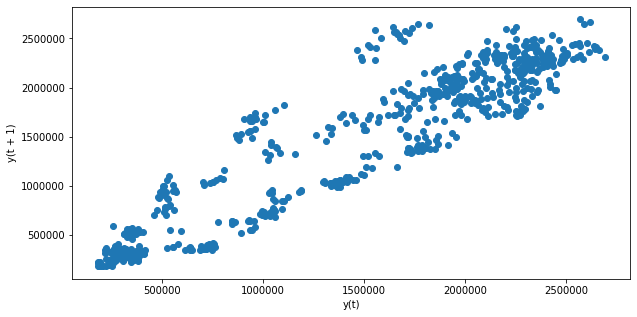

In [13]:
from pandas.plotting import lag_plot
lag_plot(ts);

Para quitar la autocorrelación completamente o hasta un grado definido (lo que también estaciona la serie), vamos a diferenciarla: crear una serie nueva en la cual cada valor es igual a la diferencia entre dos valores de la misma serie separados por el mismo intervalo.  

Hacemos dos series diferenciadas: una con el intervalo de 24 horas(el ciclo corto de la serie original) y otra con el intervalo de 168 horas (el ciclo semanal de la serie). Para cada serie diferenciada visualizamos la serie y su autocorrelación.

In [7]:
from statsmodels.tsa.statespace.tools import diff

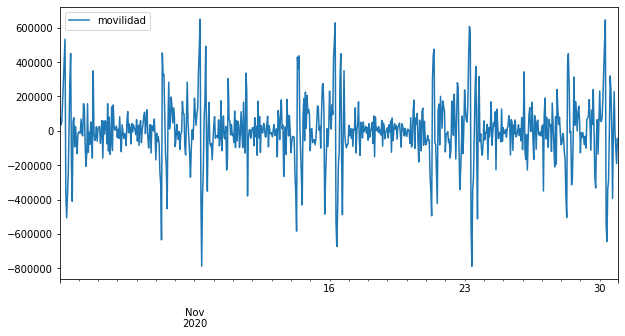

In [14]:
diff_ser = diff(ts, k_seasonal_diff=1, seasonal_periods = 24)
diff_ser.plot()

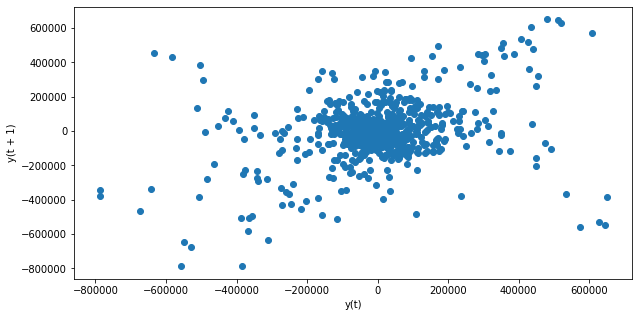

In [15]:
lag_plot(diff_ser)

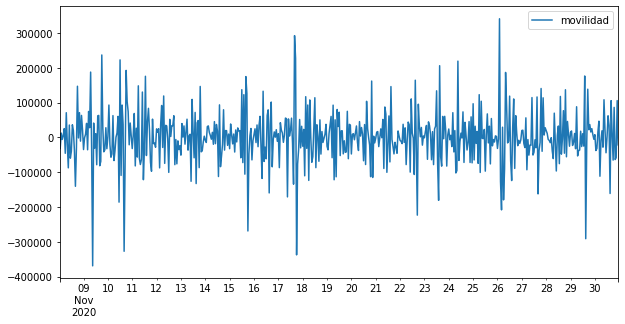

In [16]:
diff_ser = diff(ts, k_seasonal_diff=1, seasonal_periods = 24*7)
diff_ser.plot()

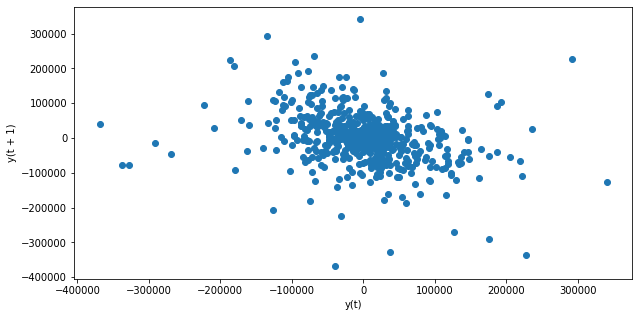

In [17]:
lag_plot(diff_ser)

Así podemos ver que las series diferenciadas sin duda tienen carácter estacionario (son muy parecidas al ruído blanco) con autocorrelación casi quitada completamente (sobre todo en la serie con el intervalo semanal entre valores).

La condición principal para poder aplicar el modelado SARIMA es que la serie sea estacionaria. Cómo antes, confirmamos esta condición por aplicar la prueba "Augmented Dickey-Fuller Test".

In [24]:
from statsmodels.tsa.stattools import adfuller

def adf_test(serie,title=''):
    
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(serie.dropna(),autolag='AIC') # .dropna() para manejar los datos en el caso de diferenciarlos
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() para quitar la linea "dtype: float64"
    
    if result[1] <= 0.05:
        print("La serie es estacionaria")
    else:
         print("La serie es NO estacionaria")

In [25]:
adf_test(ts)

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.797711
p-value                   0.002931
# lags used              20.000000
# observations          699.000000
critical value (1%)      -3.439740
critical value (5%)      -2.865684
critical value (10%)     -2.568977
La serie es estacionaria


In [26]:
adf_test(diff_ser)

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.015466e+01
p-value                 7.786786e-18
# lags used             1.600000e+01
# observations          5.340000e+02
critical value (1%)    -3.442655e+00
critical value (5%)    -2.866968e+00
critical value (10%)   -2.569661e+00
La serie es estacionaria


Según los resultados de la prueba, la serie original es estacionaria, aunque ya sabemos que tiene estacionalidad. En su turno, la serie diferenciada tiene los valores de estadisticas ADF y p-value mucho más bajos que la serie original, que supone la última serie es mucho más estacionaria.

Otra forma de visualizar autocorrelación en la serie temporal es hacer los gráficos de dos funciones importantes: la función de autocorrelación (ACF) y la función de parcial autocorrelación (PACF) en la serie temporal. Los gráficos también pueden servir para sugerir que ordenes de componentes AR y MA necesitemos utilizar para el modelo.

Hacemos los gráficos para la serie original y la serie diferenciada.

In [18]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

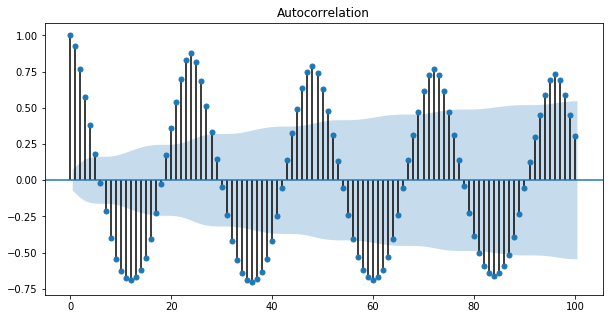

In [20]:
plot_acf(ts, lags=100);

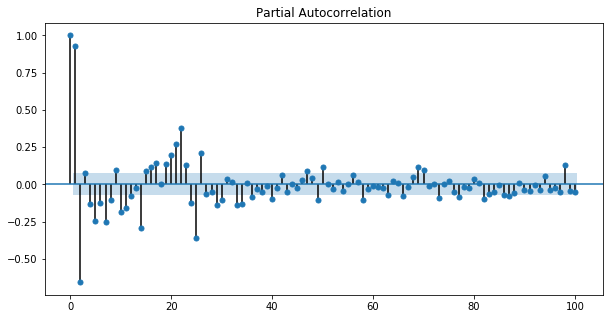

In [21]:
plot_pacf(ts, lags=100);

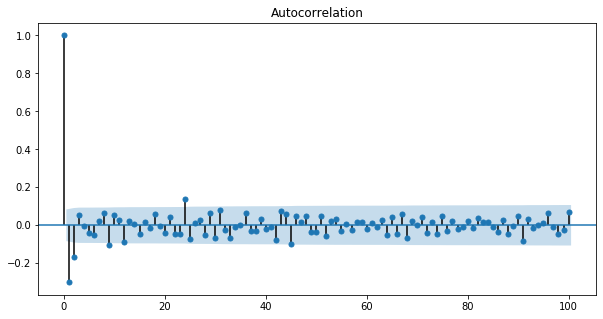

In [22]:
plot_acf(diff_ser, lags=100);

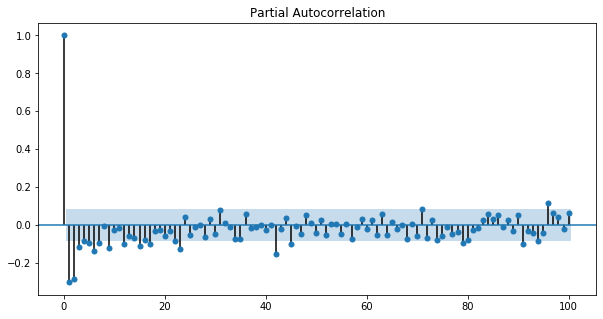

In [23]:
plot_pacf(diff_ser, lags=100);

Al comparar los gráficos ACF y PACF para las dos series podemos sacar las conclusiones siguientes: 1) es más probable que lo de diferenciar la serie original para modelarla no tenga sentido - la autocorrelación entre dos primeros valores en la serie cambia su signo despues de diferenciarla; 2) el orden del componente AR puede ser 5 o más (el número de lags en el gráfico de ACF antes de alcanzar la area de insignificancia estadistica); 3) el orden de MA puede ser igual a 2 (el numero de lags en el gráfico de PACF antes de alcanzar la area de insignificancia estadistica).

Para encontrar el mejor modelo para la serie vamos a utilizar la libreria "pmdarima" que ejecuta una búsqueda en cuadrícula de parametros óptimos.

In [27]:
from pmdarima import auto_arima

In [84]:
fit = auto_arima(ts, seasonal=True, trace=True, m=24)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=19376.026, Time=9.11 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=21596.227, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=19722.735, Time=14.69 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=20969.375, Time=1.92 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=22627.797, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=19473.937, Time=4.64 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=19375.166, Time=13.42 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=19719.838, Time=0.49 sec
 ARIMA(2,0,2)(2,0,0)[24] intercept   : AIC=19373.803, Time=29.18 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=19373.678, Time=46.78 sec
 ARIMA(2,0,2)(2,0,2)[24] intercept   : AIC=inf, Time=67.35 sec
 ARIMA(2,0,2)(1,0,2)[24] intercept   : AIC=19374.856, Time=53.69 sec
 ARIMA(1,0,2)(2,0,1)[24] intercept   : AIC=19388.613, Time=22.07 sec
 ARIMA(2,0,1)(2,0,1)[24] intercept   : AIC=inf, Time=28.43 sec
 ARIMA(3,

In [86]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  720
Model:             SARIMAX(5, 0, 3)x(1, 0, [1, 2], 24)   Log Likelihood               -9632.621
Date:                                 Mon, 18 Jan 2021   AIC                          19291.243
Time:                                         15:08:49   BIC                          19350.773
Sample:                                              0   HQIC                         19314.224
                                                 - 720                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.081e+05   6.76e-08   4.56e+12      0.000    3.08e+05    3.08e+05
ar.L1         -1.0941      0.073    -14.893      0.000      -1.238      -0.950
ar.L2          0.2257      0.079      2.856      0.004       0.071       0.381
ar.L3          0.8592      0.089      9.648      0.000       0.685       1.034
ar.L4          0.0339      0.103      0.328      0.743      -0.169       0.236
ar.L5         -0.4404      0.077     -5.712      0.000      -0.592      -0.289
ma.L1          2.3954      0.052     46.134      0.000       2.294       2.497
ma.L2          2.3630      0.088     26.964      0.000       2.191       2.535
ma.L3          0.9602      0.047     20.542      0.000       0.869       1.052
ar.S.L24       0.8641      0.020     44.000      0.000       0.826       0.903
ma.S.L24      -0.1997      0.085     -2.355      0.019      -0.366      -0.033
ma.S.L48      -0.1855      0.070     -2.665      0.008      -0.322      -0.049
sigma2      3.894e+10    1.4e-12   2.79e+22      0.000    3.89e+10    3.89e+10
===================================================================================
Ljung-Box (Q):                      135.34   Jarque-Bera (JB):                69.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.45
Prob(H) (two-sided):                  0.86   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.31e+38. Standard errors may be unstable.
"""

Los parametros óptimos del modelo SARIMA escogidos por el módulo "pmdarima" son (5,0,3) cómo los órdenes de componentes AR,I,MA y (1,0,2) cómo los órdenes de los mismos componentes de estacionalidad.

Ahora vamos a dividir la serie en dos partes: los datos de entrenamiento y de prueba, entrenar el modelo con los datos de entrenamiento, predecir los valores para las fechas del conjunto de prueba y comparar las prediciones con valores actuales.

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [30]:
train_data=ts['movilidad'][:-216]
test_data=ts['movilidad'][-216:]

In [31]:
smodel=SARIMAX(train_data, order=(5,0,3), seasonal_order=(1,0,2,24))

In [32]:
result = smodel.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                               movilidad   No. Observations:                  504
Model:             SARIMAX(5, 0, 3)x(1, 0, [1, 2], 24)   Log Likelihood               -6781.746
Date:                                 Mon, 25 Jan 2021   AIC                          13587.493
Time:                                         19:36:27   BIC                          13638.164
Sample:                                     11-01-2020   HQIC                         13607.369
                                          - 11-21-2020                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8265      0.141      5.848      0.000       0.549       1.103
ar.L2          0.4600      0.137      3.369      0.001       0.192       0.728
ar.L3          0.2765      0.138      2.003      0.045       0.006       0.547
ar.L4         -1.0354      0.131     -7.922      0.000      -1.292      -0.779
ar.L5          0.4612      0.121      3.808      0.000       0.224       0.699
ma.L1          0.4804      0.091      5.299      0.000       0.303       0.658
ma.L2         -0.3182      0.146     -2.175      0.030      -0.605      -0.032
ma.L3         -0.9314      0.145     -6.405      0.000      -1.216      -0.646
ar.S.L24       0.9874      0.030     32.960      0.000       0.929       1.046
ma.S.L24      -0.5229      0.186     -2.816      0.005      -0.887      -0.159
ma.S.L48      -0.3006      0.169     -1.779      0.075      -0.632       0.031
sigma2      5.238e+10   2.51e-12   2.09e+22      0.000    5.24e+10    5.24e+10
===================================================================================
Ljung-Box (Q):                       86.27   Jarque-Bera (JB):                39.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.20
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.37e+38. Standard errors may be unstable.
"""

In [34]:
predictions = result.predict(504,719).rename("SARIMA forecast")

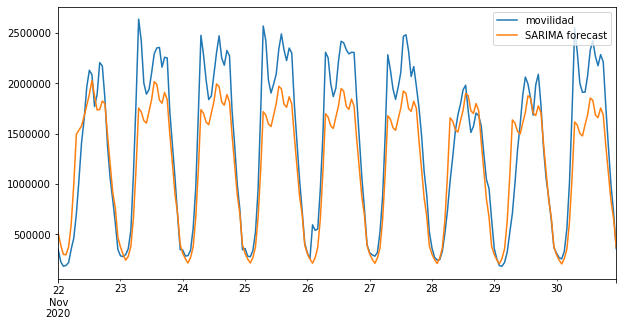

In [36]:
test_data.plot(legend=True);
predictions.plot(legend=True);

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_absolute_error(test_data, predictions)

277487.46240561217

In [39]:
np.sqrt(mean_squared_error(test_data,predictions))

349384.5677135104

El modelo SARIMA nos produce los errores de predicción un poquito más altos que el modelo de Holt-Winters (246056 y 331143 respectivamente).

Para validar la calidad de un modelo se puede analizar los residuos que esta produce. Cuanto más los residuos parecen al ruido blanco, mejor el modelo. Para visualizar la serie de los residuos y comparar su caracteristicas con las de ruido blanco utilizamos la función propia de la libreria "statsmodels".

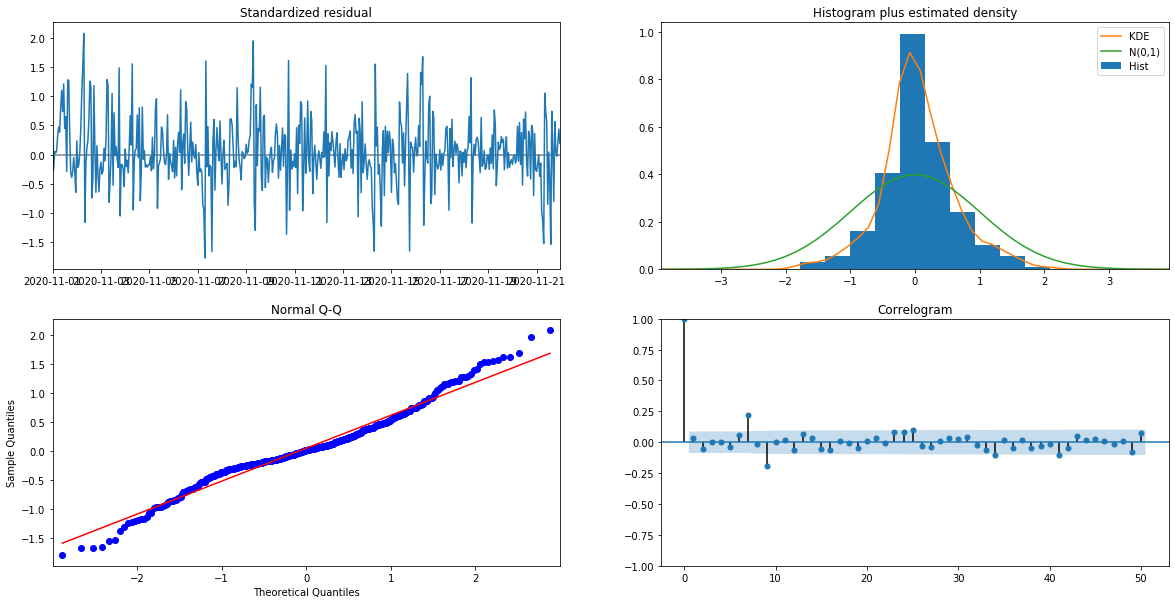

In [41]:
# plot residual diagnostics
result.plot_diagnostics(lags=50,figsize = (20,10),);

En los gráficos podemos ver que los valores residuos tienen una distribución similar a la normal, autocorrelación entre los valores no existe. Así que el modelo ha conseguido describir las caracteristicas del proceso que origina la serie temporal bastante bién. 